## Analyze A/B Test Results

This project will cover statistics lessons. 

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
total_unique_users = df.user_id.nunique()
total_unique_users

290584

d. The proportion of users converted.

In [6]:
proportion = df.query('converted == 1').user_id.nunique()/total_unique_users
proportion

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
df.groupby(['group','landing_page']).user_id.count()

group      landing_page
control    new_page          1928
           old_page        145274
treatment  new_page        145311
           old_page          1965
Name: user_id, dtype: int64

In [8]:
result=df.query('group == "control"').query('landing_page == "new_page"').user_id.count() + df.query('group == "treatment"').query('landing_page == "old_page"').user_id.count()
result

3893

The total 3893 rows are wrongly categorized data.

f. Do any of the rows have missing values?

In [9]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
df_part1 = df.query('group == "treatment"').query('landing_page == "new_page"')
df_part2 = df.query('group == "control"').query('landing_page == "old_page"')

In [11]:
df2= pd.concat([df_part1,df_part2])

We created a new dataset with the correct combinations (control, old_page) and (treatment, new_page

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
df2[df2.user_id.duplicated()==True].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [15]:
df2[df2.user_id.duplicated()==True].landing_page

2893    new_page
Name: landing_page, dtype: object

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2.drop_duplicates(subset='user_id', keep="last" , inplace=True)
df2.shape

(290584, 5)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
p_ctr=df2.query('group == "control"').converted.mean()
p_ctr

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
p_trt = df2.query('group == "treatment"').converted.mean()
p_trt

0.11880806551510564

There is a 11.88% chances of an individual getting converted if he receives an new landing page.

In [20]:
obs_diff = p_trt - p_ctr
obs_diff

-0.0015782389853555567

Observed diffrence between the conversion rate of treatement and control group is -0.15%.

d. What is the probability that an individual received the new page?

In [22]:
df2.query('landing_page == "new_page"').user_id.count() / df2.user_id.count()

0.5000619442226688

There is a 50% chance of a user getting a new old or an old page.

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**There is a probability of 11.88% of a customer to get converted if he lands on new page. And there is a 12.04% chance that a customer that received old page converted. Thus with new page the probability of conversion has decreased. There is only 50% chance of a user receiving new page which is good for our analysis as this provides a fair treatment to both the groups.**

**However, there are multiple other factors might have contributed to this lower probability of conversion with the new page.**

**1. Change aversion: Current users might take longer time to accept to the new page**

**2. Novelty effect: Users might be getting converted due to excitement of the new page. However, this behaviour might change with time**

**Due to these two factors, we cannot be sure if the treatment page is more successful in conversions or not. We need to collect data over longer period of time and repeat these tests to draw conclusion or follow a better testing method.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Alpha = 0.05**

**Null Hypothesis: Old page is as good or better than new page ( H0 ) :  pnew  <=  pold** 

**Alternate Hypothesis: New page is better than old page ( H1 ) :  pnew  >  pold.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [24]:
#Under null where success rate regarless is same, we consider both old and new pages as same
p_new=df2.converted.mean()
p_new

0.11959708724499628

There is a 11.9% conversion rate if a user converts. Under null we do not diffrentiate between control and treatement group.



b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [25]:
#Success Rate regardless of the page
p_old=df2.converted.mean()
p_old

0.11959708724499628

There is a 11.9% conversion rate if a user converts. Under null we do not diffrentiate between control and treatement group. Hence, we get the same conversion rate.

c. What is $n_{new}$?

In [26]:
n_new=df2.query('group == "treatment"').user_id.count()
n_new

145310

There are 145310 unique users in the treatment group.

d. What is $n_{old}$?

In [27]:
n_old=df2.query('group == "control"').user_id.count()
n_old

145274

There are 145274 unique users in the control group.

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [28]:
new_page_converted = np.random.choice(2,size=n_new,p = [1 - p_new,p_new], replace = True)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

We simulated n_new(145310) transactions with a conversion rate of 11.9% to get an array of 1's and 0's where 1 indicates a user is converted and 0 indicated there is no conversion.

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [29]:
old_page_converted = np.random.choice([0,1],size=n_old,p = [1 - p_old,p_old], replace = True)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

We simulated n_old(145274) transactions with a conversion rate of 11.9% to get an array of 1's and 0's where 1 indicates a user is converted and 0 indicated there is no conversion.

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [30]:
diffs=new_page_converted.mean() - old_page_converted.mean()
diffs

-0.0009654585950117228

In [31]:
diffs=new_page_converted.mean() - old_page_converted.mean()
diffs

-0.0009654585950117228

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [32]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0,1],size=n_new,p = [1 - p_new,p_new])
    old_page_converted = np.random.choice([0,1],size=n_old,p = [1 - p_old,p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())  

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0,0.5,'frequency')

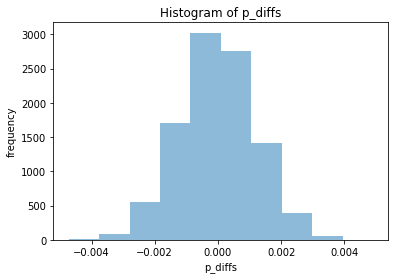

In [33]:
plt.hist(np.array(p_diffs),alpha=0.5)
plt.title("Histogram of p_diffs")
plt.xlabel("p_diffs")
plt.ylabel("frequency")

The distribution of p_diffs looks quite normally distributed and in aggrement with central limit theorem.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [36]:
(np.array(p_diffs) > obs_diff).mean()

0.9046

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The above value is call p-value 0.9046. The p-value in this case signify the probability of us observing facts that the new landing page is as good or worse than old landing page, assuming new page is truly better. Since the p value is higher than 0.05 (alpha or Type 1 error) , we fail to reject null hypothesis which means that the old landing page is as good or better than the new landing page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [37]:
import statsmodels.api as sm

convert_old = sum((df2.group == 'control') & (df2.converted==1))
convert_new = sum((df2.group == 'treatment') & (df2.converted==1))
n_old = sum(df2.group == 'control')
n_new = sum(df2.group == 'treatment')
convert_old, convert_new, n_old,n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [38]:
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')
print(z_score,p_value)

-1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**z-score indicates we are -1.3109 standard deviations below the actual population mean. Since the p-value(0.9050) is lower than alpha or type 1 error(0.05), we fail to reject null hypothesis and can conclude that the old landing page is as good or better than new landing page.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**There are two variables: converted and group/landing_page(Explanotory variable). Both the variables are categorical. Since we are predicting converted value between 0 and 1 (non-continous) we will use 'Logistic Regression' model.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [39]:
df2['intercept'] = 1
df2[['ab_page','old_page']] = pd.get_dummies(df['landing_page'])
#we do not need old page column as new page column can represent both information
df2=df2.drop('old_page',axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [40]:
logit_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [41]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-12-21 20:38 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**p value is 0.1899 which is greater than 0.05(Type I error). this indicates the variable ab_page does not have any statistically significance in predicting conversion.

Null Hypothesis: There is no difference in conversion of new page and old page. Alternate Hypothesis: There is a difference of conversion generated by new page against old page.

In regression model, we assume that there is no difference in conversion of old and new page as the null Hypothesis. In Part 2, however, the null hypothesis is that the old page page is as good or better than new page.

Similarly, alternative hypothesis in Part 2 was something we wanted to prove, i.e new page is better than the old page.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It was observed that landing page did not have any statistical impact on the user conversion. More variables could mean we require a higher order variables which adds a complication. As in this case, we might have to also find out the interaction between these variables and our model will no longer be linear.

Out of the provided data : timestamp looks like a variable which can be considered to be added to our model. We can use (Month OR Time of the day:Day/Night) as additional variables to help us predict the user conversion.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [42]:
dfc=pd.read_csv('countries.csv')
dfc.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [43]:
df3=pd.merge(df2,dfc,how='left',on='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [44]:
df3.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [45]:
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3['intercept'] = 1
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0


In [46]:
#We will use logistic regression as the prediction value is categorical. We will use CA as the baseline country
logit_mod2 = sm.Logit(df3['converted'],df3[['intercept','ab_page','UK','US']])
results2 = logit_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2020-12-21 20:39 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

Since the p-values are higher than 0.05 for all variables, our variables are not statistically significant for predicting conversion on the page.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [47]:
### Fit Your Linear Model And Obtain the Results
#Interaction variables between the countries(UK and US) and ab_page
df3['UK_ab_page'] = df3['ab_page']* df3['UK']
df3['US_ab_page'] = df3['ab_page']* df3['US']
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,UK_ab_page,US_ab_page
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0,0,0


In [48]:
#We will use logistic regression as the prediction value is categorical. We will use CA as the baseline country
logit_mod3 = sm.Logit(df3['converted'],df3[['intercept','ab_page','UK_ab_page','US_ab_page','UK','US']])
results3 = logit_mod3.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2020-12-21 20:43 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
==================================================================

"""

**Since p-value for none of the variables is lower than 0.05, there is no statistical significance observed even with variable interactions.**

In [49]:
1/np.exp(-0.0674),np.exp(0.0783),np.exp(0.0469),np.exp(0.0118),np.exp(0.0175)

(1.0697232819209153,
 1.0814470441230692,
 1.048017202119183,
 1.011869894648401,
 1.0176540221507617)

If the results were statistically significant, we could have interpreted the results as follows:

For every unit of decrease for ab_page, 6.9% users are more likely to convert,given the other variables remain constant.

For every unit of decrease for UK new page compared to CA new page, 8.14% users are more likely to convert,given the other variables remain constant.

For every unit of decrease for US new page compared to CA new page , 4.8% users are more likely to convert,given the other variables remain constant.

For every unit of decrease for UK compared to CA, 1.18% users are more likely to convert,given the other variables remain constant.

For every unit of decrease for US compared to CA, 1.76% users are more likely to convert,given the other variables remain constant.

The regression models due to higher p value than 0.05 do not indicate statistical significance. So there is little impact on user conversion rate, based on user country or if the user receives the new page.

<a id='conclusions'></a>
## Conclusions

In conclusion, user country or landing page cannot be co-related with user conversion rate. Based on the p-values, we can conclude that the old page is as good as or better than the new page. Decision on using the new or old page should now be based on other factors such as costs of rolling out the new landing page or seek more variables that could potentially impact the conversion rate and repeat the process.